# Iris&digits


In [19]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import matplotlib.lines as mlines
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

iris=load_iris()

X_i = iris.data
Y_i = iris.target

In [1]:
Y = (Y_i>0).astype(int)*2 - 1
pca = PCA(n_components=2)
X = pca.fit_transform(X_i)

def bias_feature(x):
        extended = np.zeros((x.shape[0], x.shape[1]+1))
        extended[:,:-1] = x
        extended[:,-1] = int(1)
        return extended
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2021)

NameError: name 'Y_i' is not defined

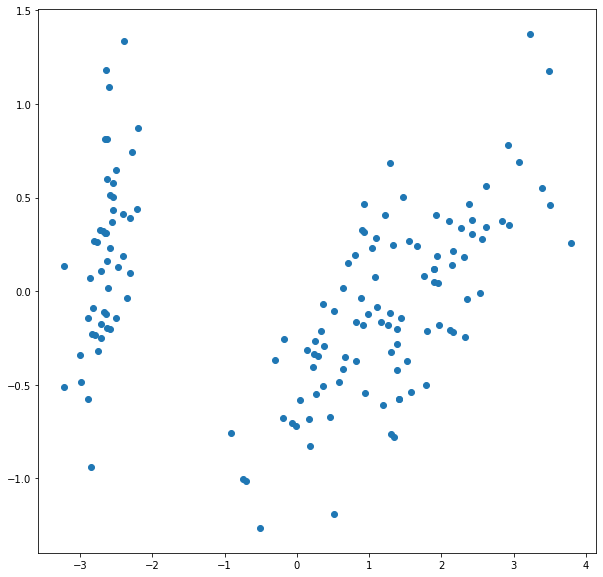

In [21]:
fig, ax=plt.subplots(figsize=(10,10))
ax.scatter(X[:,0], X[:,1])

In [22]:
clf=svm.SVC(kernel='linear', C=10)
clf.fit(X_train, Y_train)

SVC(C=10, kernel='linear')

# К задаче кросс-корреляции

In [29]:
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from sqlite3 import connect
import pandas as pd
from collections import defaultdict
import os
import time
import numpy as np

class Image:
    def __init__(self, fname='', hdr={}, data=[]):
        self._fname = fname
        self.hdr = hdr
        self.data = data
    
    @property
    def width(self):
        try:
            return self.data.shape[0]
        except Exception as e:
            return 0
    
    @property
    def height(self):
        try:
            return self.data.shape[1]
        except:
            return 0
    
    @property
    def fname(self):
        return self._fname
    
    def __str__(self):
        return f"<Image {self.width}x{self.height}>"
    
    __repr__ = __str__
    
def imread(path):
    hdr, data = {}, []
    with fits.open(path, 'readonly', ignore_missing_end=True) as f:
        hdu = f[0]
        hdr = getattr(hdu, 'header', {})
        data = getattr(hdu, 'data', [])
        
    return Image(path, hdr=hdr, data=data)

def imsave(img, path=''):
    if path:
        fits.writeto(path, img.data, img.hdr, overwrite=True)
    else:
        fits.writeto(img.fname, img.data, img.hdr, overwrite=True)
        
def sql2pandas(db_path):
    
    df = defaultdict(list)
    cols = ['x', 'x_err', 'y', 'y_err', 'ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']
    
    if not os.path.isfile(db_path):
        raise IOError(f"No such file \"{db_path}\"")
    
    with connect(db_path) as conn:
        for row in conn.cursor().execute(
            'SELECT x, x_err, y, y_err, ra_deg, ra_err, dec_deg, dec_err, mag, mag_err FROM objects'):
            df['x'].append(row[0])
            df['x_err'].append(row[1])
            df['y'].append(row[2])
            df['y_err'].append(row[3])
            df['ra_deg'].append(row[4])
            df['ra_err'].append(row[5])
            df['dec_deg'].append(row[6])
            df['dec_err'].append(row[7])
            df['mag'].append(row[8])
            df['mag_err'].append(row[9])
            
    return pd.DataFrame(df, columns=cols)

img = imread('test.fits')
img_objects = sql2pandas('test.db')

w = WCS(img.hdr)

xscale, yscale = (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)
field_center = SkyCoord(*w.wcs.crval, unit=[u.deg, u.deg])
region_width = img.width * xscale/2
region_height = img.height * yscale/2

ps1 = Vizier(catalog='II/349', row_limit=-1).query_region(field_center,
                                                        width=region_width,
                                                        height=region_height)[0]


sdss9 = Vizier(catalog='V/139', row_limit=-1).query_region(field_center,
                                                        width=region_width,
                                                        height=region_height)[0]


def tree(c1, c2, epsilon):
    
    start_time = time.time()
    
    matches = []
    no_matches = []
    
    
    coords1_sc = SkyCoord(c1[:, 1:]*u.degree, frame='icrs')
    coords2_sc = SkyCoord(c2[:, 1:]*u.degree, frame='icrs')
    

    closest_ids, closest_dists, _ = coords1_sc.match_to_catalog_sky(coords2_sc)
    
    for id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
      
        if closest_dist > epsilon:
            no_matches.append(id1)
        else:
            matches.append([id1, closest_id2, closest_dist])
    
    return matches, no_matches, time.time() - start_time

np.max(sdss9['rmag'])

26.888

# Данные

In [ ]:
xps = np.array(ps1['RAJ2000'], dtype=float)
yps = np.array(ps1['DEJ2000'], dtype=float)

xsd = np.array(sdss9['RA_ICRS'], dtype=float)
ysd = np.array(sdss9['DE_ICRS'], dtype=float)

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(xps, yps, marker = 'o',
                   c = 'r',
                   s=25,
                   linewidths = 2,
                   edgecolors = 'darkred',
          alpha=0.75)

ax.scatter(xsd, ysd, s=1, c='w')
ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.show()

In [6]:
ps1_features={'RA': ps1['RAJ2000'], 'DE': ps1['DEJ2000'], 'g': ps1['gmag'], 'r': ps1['rmag'], 'i': ps1['imag'], 'z': ps1['zmag']}
ps1_features=pd.DataFrame(data=ps1_features)
ps1_filtered=ps1_features.dropna() #чистка каталога PanSTARRS от объектов без магнитуд


ps1_coords=pd.DataFrame(data={'RA': ps1_filtered['RA'], 'DE': ps1_filtered['DE']})
ps1_coords=ps1_coords.to_numpy() 

numpy_ps1_filtered=pd.DataFrame(data={'RA': ps1_filtered['RA'], 'DE': ps1_filtered['DE'], 'r': ps1_filtered['r']})
numpy_ps1_filtered=numpy_ps1_filtered.to_numpy()

In [7]:
sdss_features={'RA': sdss9['RA_ICRS'], 'DE': sdss9['DE_ICRS'], 'g': sdss9['gmag'], 'r': sdss9['rmag'], 'i': sdss9['imag'], 'z': sdss9['zmag']}
sdss_features=pd.DataFrame(data=sdss_features)
sdss_features=sdss_features.to_numpy()

sdss_filtered=[]
 
for obj in sdss_features:  #чистка каталога SDSS от объектов с магнитудами >24
    n=0
    for k in obj[2:]:
        if k>24:
            n+=1
    if n==0:
        sdss_filtered.append(obj)
        
sdss_filtered=pd.DataFrame(data=sdss_filtered, columns=['RA', 'DE', 'g', 'r', 'i', 'z'])            

sdss_coords=pd.DataFrame(data={'RA': sdss_filtered['RA'], 'DE': sdss_filtered['DE']})
sdss_coords=sdss_coords.to_numpy()

numpy_sdss_filtered=pd.DataFrame(data={'RA': sdss_filtered['RA'], 'DE': sdss_filtered['DE'], 'r': sdss_filtered['r']})
numpy_sdss_filtered=numpy_sdss_filtered.to_numpy()

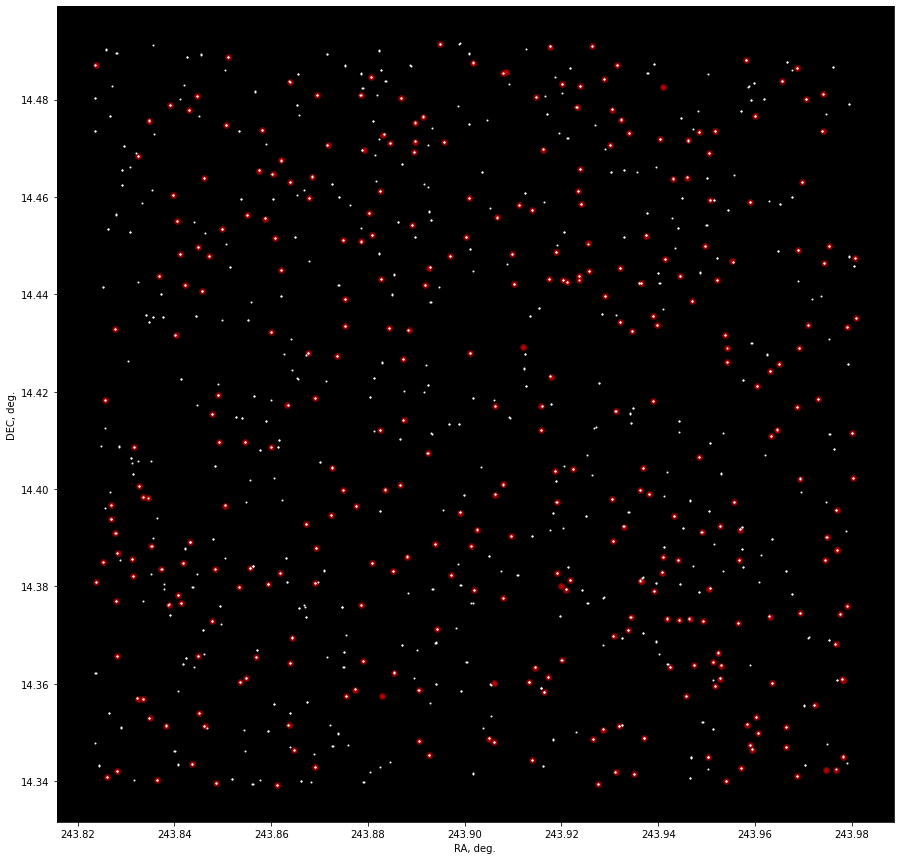

In [8]:
xps_filtered = np.array(ps1_filtered['RA'], dtype=float)
yps_filtered = np.array(ps1_filtered['DE'], dtype=float)

xsd_filtered = np.array(sdss_filtered['RA'], dtype=float)
ysd_filtered = np.array(sdss_filtered['DE'], dtype=float)

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(xps_filtered, yps_filtered, marker = 'o',
                   c = 'r',
                   s=25,
                   linewidths = 2,
                   edgecolors = 'darkred',
          alpha=0.75)

ax.scatter(xsd_filtered, ysd_filtered, s=1, c='w')
ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.show()

In [9]:
coords1_sc = SkyCoord(ps1_coords*u.degree, frame='icrs')
coords2_sc = SkyCoord(sdss_coords*u.degree, frame='icrs')

closest_ids, closest_dists, _ = coords1_sc.match_to_catalog_sky(coords2_sc)

matches = []
no_matches = []
epsilon=3

for id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
      
        if closest_dist > epsilon/3600:
            no_matches.append(id1)
        else:
            matches.append([id1, closest_id2, closest_dist])
            
matches
no_matches


print(matches[0][1], matches[1][1], matches[2][1], no_matches)

ps_visual_x= np.array((ps1_coords[0][0], ps1_coords[1][0], ps1_coords[2][0]))
ps_visual_y= np.array((ps1_coords[0][1], ps1_coords[1][1], ps1_coords[2][1]))              
                      
sdss_visual_x=np.array((sdss_coords[66][0], sdss_coords[47][0], sdss_coords[80][0]))
sdss_visual_y=np.array((sdss_coords[66][1], sdss_coords[47][1], sdss_coords[80][1]))

835 1084 1102 [41, 56, 108, 237, 301]


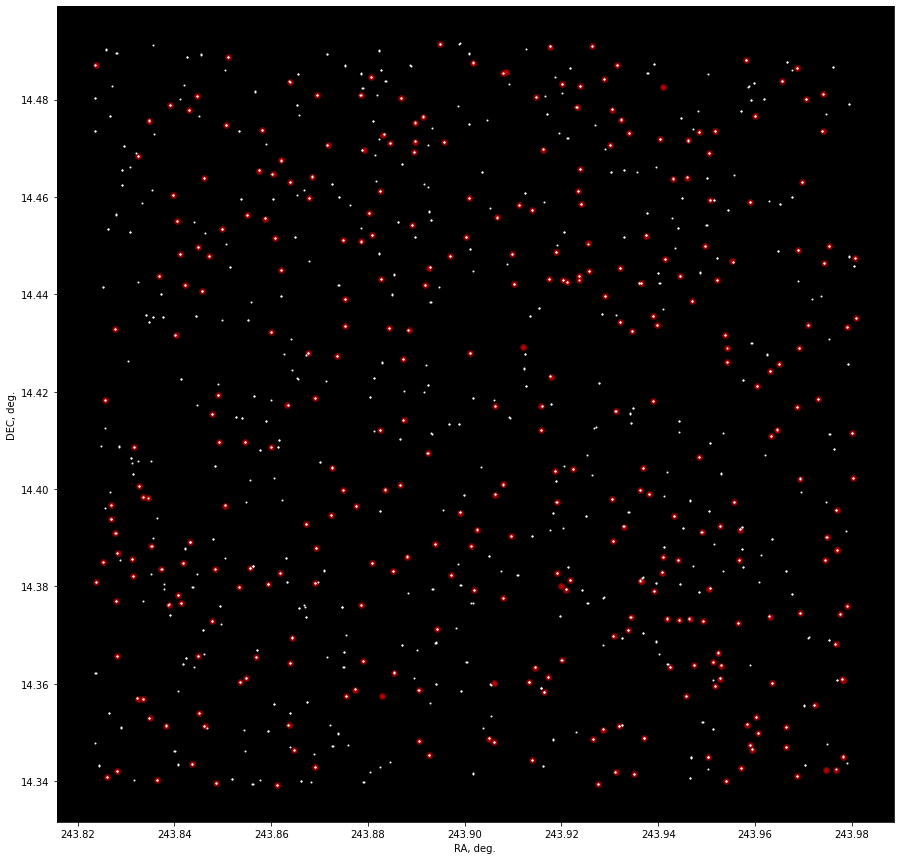

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(xps_filtered, yps_filtered, marker = 'o',
                   c = 'r',
                   s=25,
                   linewidths = 2,
                   edgecolors = 'darkred',
          alpha=0.75)

ax.scatter(xsd_filtered, ysd_filtered, s=1, c='w')
ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
#ax.scatter(ps_visual_x, ps_visual_y, s=200, c='b')
#ax.scatter(sdss_visual_x, ps_visual_y, s=75, c='y')
#ax.scatter(ps1_coords[no_matches[0]][0], ps1_coords[no_matches[0]][1] , s=750, c='g', marker='x')
plt.show()

In [12]:
def distance(ra1, dec1, ra2, dec2):
    
    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2
    
    angle = 2*np.arcsin(np.sqrt(a + b))
    
    return np.degrees(angle)


ps_ra=numpy_ps1_filtered[0][0]
ps_de=numpy_ps1_filtered[0][1]
ps_r=numpy_ps1_filtered[0][2]

k=np.random.randint(1, 48, 3)
print(k)

sdss_ra=numpy_sdss_filtered[k][:,0]
sdss_de=numpy_sdss_filtered[k][:,1]
sdss_r=numpy_sdss_filtered[k][:,2]


distance(ps_ra, ps_de, sdss_ra, sdss_de)
ps_r-sdss_r



[15 14 31]


array([-1.48029947, -1.7423005 , -1.92729997])

In [13]:
import random


features=[]
target=[]

for i in range(numpy_ps1_filtered.shape[0]-10):
    
    features.append((matches[i][2], numpy_ps1_filtered[matches[i][0]][2]-numpy_sdss_filtered[matches[i][1]][2]))
    target.append(1)
    
    k=random.randint(1, 48)

    ps_ra=numpy_ps1_filtered[i][0]
    ps_de=numpy_ps1_filtered[i][1]
    ps_r=numpy_ps1_filtered[i][2]
    
    sdss_ra=numpy_sdss_filtered[k][0]
    sdss_de=numpy_sdss_filtered[k][1]
    sdss_r=numpy_sdss_filtered[k][2]
    
    features.append((distance(ps_ra, ps_de, sdss_ra, sdss_de), ps_r-sdss_r))
    target.append(-1)
    
    k=random.randint(1, 48)
    
    sdss_ra=numpy_sdss_filtered[k][0]
    sdss_de=numpy_sdss_filtered[k][1]
    sdss_r=numpy_sdss_filtered[k][2]
    
    features.append((distance(ps_ra, ps_de, sdss_ra, sdss_de), ps_r-sdss_r))
    target.append(-1)
    
    k=random.randint(1, 48)
    
    sdss_ra=numpy_sdss_filtered[k][0]
    sdss_de=numpy_sdss_filtered[k][1]
    sdss_r=numpy_sdss_filtered[k][2]
    
    features.append((distance(ps_ra, ps_de, sdss_ra, sdss_de), ps_r-sdss_r))
    target.append(-1)
    

features

[(2.3161259105495486e-05, 0.8107009002685537),
 (3.3786244786241038, -0.5002999237060557),
 (3.5147986185851785, -3.749300473022462),
 (3.3786244786241038, -0.5002999237060557),
 (2.1153089287818206e-05, 0.7000991912841812),
 (3.055322894872536, 0.005099496459962438),
 (3.4935237131775287, 1.2471000762939468),
 (6.088712984569593, -0.43890074768066256),
 (3.334211937446057e-05, 0.4971002288818376),
 (4.689351721212937, 0.6631005950927751),
 (2.957722935522254, -1.8349005035400374),
 (1.5515816981694432, -2.0588995269775374),
 (4.286102559272393e-06, 0.7063004882812507),
 (3.6101388978483633, -2.175699481201171),
 (7.953614652739285, 1.5002992065429694),
 (4.109439943509299, 1.597299328613282),
 (2.8064096446435688e-05, 0.3494994506835951),
 (1.8083224991677285, -1.8604996337890611),
 (1.263857629857008, -1.7434990539550768),
 (8.650714828668034, -2.9835007324218736),
 (1.4944318472715066e-05, 0.010700778198241778),
 (8.216641928744822, -5.580300732421875),
 (1.2540613570913146, -5.4103

In [14]:
features=np.array(features)

NameError: name 'features' is not defined

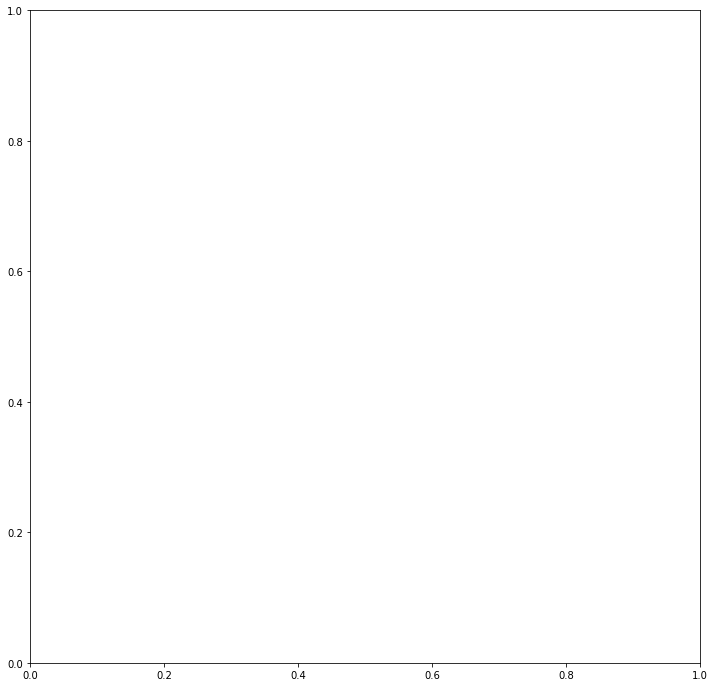

In [2]:
import seaborn as sns

fig, ax=plt.subplots(figsize=(12,12))
sns.scatterplot(x=features[:,0], y=features[:,1], hue=target, palette="deep")
plt.xlim(-1, 3)